In [1]:
#import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,make_scorer,average_precision_score,f1_score,recall_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shap

In [2]:
#Load data
df = pd.read_csv('/kaggle/input/telco-customer-churn-11-1-3/telco.csv')
df.head()

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges


In [3]:
# Check the size of the dataframe
print(f"Shape :{df.shape}")
# Check the columns
print(f"Columns: {df.columns}")

Shape :(7043, 50)
Columns: Index(['Customer ID', 'Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married',
       'Dependents', 'Number of Dependents', 'Country', 'State', 'City',
       'Zip Code', 'Latitude', 'Longitude', 'Population', 'Quarter',
       'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Offer',
       'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score', 'Customer Status', 'Churn Label',
       'Churn Score', 'CLTV', 'Churn Category', 'Churn Reason'],
      dtype='object'

In [4]:
# We need to drop the following columns since they are highly correlated to target and should not be used for prediction
#found high correlation  between target var and satisfaction score later so removing it as well
df.drop(['Churn Score', 'CLTV','Churn Category','Churn Reason','Satisfaction Score', 'Customer Status' ],axis=1,inplace=True)

In [5]:
df.head()

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,Yes
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10,Yes
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88,Yes
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07,Yes
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36,Yes


In [6]:
df['Country'].unique()

array(['United States'], dtype=object)

In [7]:
df['State'].unique()

array(['California'], dtype=object)

In [8]:
df['City'].unique()

array(['Los Angeles', 'Inglewood', 'Whittier', ..., 'Topaz', 'Jacumba',
       'Holtville'], dtype=object)

In [9]:
df['Payment Method'].unique()

array(['Bank Withdrawal', 'Credit Card', 'Mailed Check'], dtype=object)

In [10]:
#Removing unnecessary columns which do not have any info
df.drop(['Customer ID','Country','State','Quarter'],axis=1,inplace=True)
df.head()

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,City,Zip Code,Latitude,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
0,Male,78,No,Yes,No,No,0,Los Angeles,90022,34.023810,...,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,Yes
1,Female,74,No,Yes,Yes,Yes,1,Los Angeles,90063,34.044271,...,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10,Yes
2,Male,71,No,Yes,No,Yes,3,Los Angeles,90065,34.108833,...,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88,Yes
3,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,33.936291,...,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07,Yes
4,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,33.972119,...,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36,Yes


In [11]:
 # Remove whitespaces from city column
df['Payment Method'].replace(' ','',regex=True,inplace=True)
df.head()

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,City,Zip Code,Latitude,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
0,Male,78,No,Yes,No,No,0,Los Angeles,90022,34.023810,...,Month-to-Month,Yes,BankWithdrawal,39.65,39.65,0.00,20,0.00,59.65,Yes
1,Female,74,No,Yes,Yes,Yes,1,Los Angeles,90063,34.044271,...,Month-to-Month,Yes,CreditCard,80.65,633.30,0.00,0,390.80,1024.10,Yes
2,Male,71,No,Yes,No,Yes,3,Los Angeles,90065,34.108833,...,Month-to-Month,Yes,BankWithdrawal,95.45,1752.55,45.61,0,203.94,1910.88,Yes
3,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,33.936291,...,Month-to-Month,Yes,BankWithdrawal,98.50,2514.50,13.43,0,494.00,2995.07,Yes
4,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,33.972119,...,Month-to-Month,Yes,BankWithdrawal,76.50,2868.15,0.00,0,234.21,3102.36,Yes


In [12]:
df.columns = df.columns.str.replace(' ','_')
df.head()

,Gender,Age,Under_30,Senior_Citizen,Married,Dependents,Number_of_Dependents,City,Zip_Code,Latitude,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Churn_Label
0,Male,78,No,Yes,No,No,0,Los Angeles,90022,34.023810,...,Month-to-Month,Yes,BankWithdrawal,39.65,39.65,0.00,20,0.00,59.65,Yes
1,Female,74,No,Yes,Yes,Yes,1,Los Angeles,90063,34.044271,...,Month-to-Month,Yes,CreditCard,80.65,633.30,0.00,0,390.80,1024.10,Yes
2,Male,71,No,Yes,No,Yes,3,Los Angeles,90065,34.108833,...,Month-to-Month,Yes,BankWithdrawal,95.45,1752.55,45.61,0,203.94,1910.88,Yes
3,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,33.936291,...,Month-to-Month,Yes,BankWithdrawal,98.50,2514.50,13.43,0,494.00,2995.07,Yes
4,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,33.972119,...,Month-to-Month,Yes,BankWithdrawal,76.50,2868.15,0.00,0,234.21,3102.36,Yes


In [13]:
df.replace(' ', '_', regex=True, inplace=True)

**Identifying missing data**

In [14]:
full_description = df.describe(include='all').T
full_description

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,7043.0,NaN,NaN,NaN,46.509726,16.750352,19.0,32.0,46.0,60.0,80.0
Under_30,7043,2,No,5642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Senior_Citizen,7043,2,No,5901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,5416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_Dependents,7043.0,NaN,NaN,NaN,0.468692,0.962802,0.0,0.0,0.0,0.0,9.0
City,7043,1106,Los_Angeles,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zip_Code,7043.0,NaN,NaN,NaN,93486.070567,1856.767505,90001.0,92101.0,93518.0,95329.0,96150.0
Latitude,7043.0,NaN,NaN,NaN,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127


In [15]:
missing_data = df[df['Offer'].isnull()]
missing_data

,Gender,Age,Under_30,Senior_Citizen,Married,Dependents,Number_of_Dependents,City,Zip_Code,Latitude,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Churn_Label
0,Male,78,No,Yes,No,No,0,Los_Angeles,90022,34.023810,...,Month-to-Month,Yes,BankWithdrawal,39.65,39.65,0.00,20,0.00,59.65,Yes
16,Male,66,No,Yes,No,No,0,Alpine,91901,32.827184,...,Month-to-Month,Yes,BankWithdrawal,74.50,606.55,0.00,0,14.24,620.79,Yes
23,Female,77,No,Yes,No,No,0,San_Diego,92122,32.857230,...,Month-to-Month,Yes,BankWithdrawal,41.90,840.10,0.00,0,0.00,840.10,Yes
24,Male,71,No,Yes,Yes,No,0,San_Diego,92122,32.857230,...,Month-to-Month,No,CreditCard,30.75,805.10,0.00,140,0.00,945.10,Yes
25,Male,79,No,Yes,Yes,No,0,San_Diego,92122,32.857230,...,Month-to-Month,No,MailedCheck,19.95,214.75,0.00,0,324.94,539.69,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,62,No,No,No,No,0,Yucca_Valley,92284,34.159534,...,One_Year,No,BankWithdrawal,60.65,743.30,40.41,0,0.00,702.89,No
7038,Female,30,No,No,No,No,0,Landers,92285,34.341737,...,Two_Year,Yes,BankWithdrawal,21.15,1419.40,19.31,0,1639.44,3039.53,No
7040,Female,30,No,No,Yes,Yes,2,Amboy,92304,34.559882,...,One_Year,Yes,CreditCard,103.20,7362.90,45.38,0,2135.52,9453.04,No
7041,Female,32,No,No,Yes,Yes,2,Angelus_Oaks,92305,34.167800,...,Month-to-Month,Yes,BankWithdrawal,29.60,346.45,27.24,0,0.00,319.21,No


**EDA**

In [16]:
full_data = df.groupby(['Contract','Under_30','Churn_Label'])[['Gender']].count()
full_data

Gender
Contract       Under_30 Churn_Label        
Month-to-Month No       No             1500
                        Yes            1393
               Yes      No              455
                        Yes             262
One_Year       No       No             1094
                        Yes             132
               Yes      No              290
                        Yes              34
Two_Year       No       No             1483
                        Yes              40
               Yes      No              352
                        Yes               8

In [17]:
missing_data = df[(df['Offer'].isnull()) ]
missing_data2 = missing_data.groupby(['Under_30','Contract'])[['Gender']].count()

In [18]:
missing_data2

Gender
Under_30 Contract              
No       Month-to-Month    1614
         One_Year           676
         Two_Year           835
Yes      Month-to-Month     406
         One_Year           166
         Two_Year           180

**Handling missing values and creating rich features**

XGBoost can handle missing values be default

In [19]:
# Define the custom labels for missing values
OLDER_MISSING_LABEL = 'Offer_Missing_Age_30_Plus'
YOUNGER_MISSING_LABEL = 'Offer_Missing_Age_Under_30'
    
# Create the new imputed column, starting with the original values
df['Offer_Imputed'] = df['Offer']

# Fill NaN values based on the age condition
# For NaN rows: if Age >= 30, use the older label; otherwise, use the younger label.

# Identify rows where Offer is currently missing (NaN)
missing_mask = df['Offer_Imputed'].isna()

# Apply the older label imputation
df.loc[(df['Age'] >= 30) & missing_mask, 'Offer_Imputed'] = OLDER_MISSING_LABEL

# Apply the younger label imputation (Age < 30)
df.loc[(df['Age'] < 30) & missing_mask, 'Offer_Imputed'] = YOUNGER_MISSING_LABEL

# Finally, convert the new imputed column to the 'category' dtype
# df['Offer_Imputed'] = df['Offer_Imputed'].astype('category')

In [20]:
for col in df.columns:
    print(f"Column {col}: {df[col].dtype},{df[col].unique()}")
    

Column Gender: object,['Male' 'Female']
Column Age: int64,[78 74 71 80 72 76 66 70 77 65 67 68 69 79 75 73 37 19 31 23 38 21 29 61
 27 20 56 51 48 32 34 41 30 26 62 64 45 53 63 42 24 54 39 43 50 22 40 47
 60 52 55 59 49 58 25 28 33 44 57 46 36 35]
Column Under_30: object,['No' 'Yes']
Column Senior_Citizen: object,['Yes' 'No']
Column Married: object,['No' 'Yes']
Column Dependents: object,['No' 'Yes']
Column Number_of_Dependents: int64,[0 1 3 2 5 4 6 7 8 9]
Column City: object,['Los_Angeles' 'Inglewood' 'Whittier' ... 'Topaz' 'Jacumba' 'Holtville']
Column Zip_Code: int64,[90022 90063 90065 ... 91934 92105 92250]
Column Latitude: float64,[34.02381  34.044271 34.108833 ... 32.649787 32.741859 32.811001]
Column Longitude: float64,[-118.156582 -118.185237 -118.229715 ... -116.2237   -117.090353
 -115.152865]
Column Population: int64,[68701 55668 47534 ...   116 73006  8062]
Column Referred_a_Friend: object,['No' 'Yes']
Column Number_of_Referrals: int64,[ 0  1  6  2  4  3  7  5  8  9 10 11]
C

In [21]:
# converting object to category to avoid one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns

# Convert the dtype
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [22]:
df.dtypes

Gender                               category
Age                                     int64
Under_30                             category
Senior_Citizen                       category
Married                              category
Dependents                           category
Number_of_Dependents                    int64
City                                 category
Zip_Code                                int64
Latitude                              float64
Longitude                             float64
Population                              int64
Referred_a_Friend                    category
Number_of_Referrals                     int64
Tenure_in_Months                        int64
Offer                                category
Phone_Service                        category
Avg_Monthly_Long_Distance_Charges     float64
Multiple_Lines                       category
Internet_Service                     category
Internet_Type                        category
Avg_Monthly_GB_Download           

In [23]:
df.head()

,Gender,Age,Under_30,Senior_Citizen,Married,Dependents,Number_of_Dependents,City,Zip_Code,Latitude,...,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Churn_Label,Offer_Imputed
0,Male,78,No,Yes,No,No,0,Los_Angeles,90022,34.023810,...,Yes,BankWithdrawal,39.65,39.65,0.00,20,0.00,59.65,Yes,Offer_Missing_Age_30_Plus
1,Female,74,No,Yes,Yes,Yes,1,Los_Angeles,90063,34.044271,...,Yes,CreditCard,80.65,633.30,0.00,0,390.80,1024.10,Yes,Offer_E
2,Male,71,No,Yes,No,Yes,3,Los_Angeles,90065,34.108833,...,Yes,BankWithdrawal,95.45,1752.55,45.61,0,203.94,1910.88,Yes,Offer_D
3,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,33.936291,...,Yes,BankWithdrawal,98.50,2514.50,13.43,0,494.00,2995.07,Yes,Offer_C
4,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,33.972119,...,Yes,BankWithdrawal,76.50,2868.15,0.00,0,234.21,3102.36,Yes,Offer_C


In [24]:
# Data used to make predictions
X = df.drop(['Churn_Label'],axis=1)
X.head()

,Gender,Age,Under_30,Senior_Citizen,Married,Dependents,Number_of_Dependents,City,Zip_Code,Latitude,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Offer_Imputed
0,Male,78,No,Yes,No,No,0,Los_Angeles,90022,34.023810,...,Month-to-Month,Yes,BankWithdrawal,39.65,39.65,0.00,20,0.00,59.65,Offer_Missing_Age_30_Plus
1,Female,74,No,Yes,Yes,Yes,1,Los_Angeles,90063,34.044271,...,Month-to-Month,Yes,CreditCard,80.65,633.30,0.00,0,390.80,1024.10,Offer_E
2,Male,71,No,Yes,No,Yes,3,Los_Angeles,90065,34.108833,...,Month-to-Month,Yes,BankWithdrawal,95.45,1752.55,45.61,0,203.94,1910.88,Offer_D
3,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,33.936291,...,Month-to-Month,Yes,BankWithdrawal,98.50,2514.50,13.43,0,494.00,2995.07,Offer_C
4,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,33.972119,...,Month-to-Month,Yes,BankWithdrawal,76.50,2868.15,0.00,0,234.21,3102.36,Offer_C


In [25]:
# Data to predict.
# y = df['Churn_Label']
df['Churn_val'] = np.where(df['Churn_Label'].str.lower() == 'yes', 1, 0)
y= df['Churn_val']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_val, dtype: int64

**One hot encoding not required in modern xgboost**

In [26]:
# X_encoded = pd.get_dummies(X, columns=[
#     'City', 'Gender', 'Senior_Citizen', 'Married', 'Dependents',
#     'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Online_Security',
#     'Online_Backup', 'Device_Protection_Plan', 'Premium_Tech_Support', 'Streaming_TV',
#     'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method'
# ], dtype='int')
# X_encoded.head()

**Building a preliminary model**

In [27]:
sum(y)/len(y)

0.2653698707936959

In [28]:
#Creating train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [29]:
sum(y_train)/len(y_train)

0.2654297614539947

In [30]:
sum(y_test)/len(y_test)

0.26519023282226006

In [31]:
print(f"Training Size: {len(X_train)}")
print(f"Test Size: {len(X_test)}")
print(f'Training Set Shape: {X_train.shape}')

Training Size: 5282
Test Size: 1761
Training Set Shape: (5282, 40)


In [32]:
print(f"Training Size: {len(y_train)}")
print(f"Test Size: {len(y_test)}")
print(f'Training Set Shape: {y_train.shape}')

Training Size: 5282
Test Size: 1761
Training Set Shape: (5282,)


Using XGBoost

In [33]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42,enable_categorical=True) # to handle categorical values like object data type
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.72833
[1]	validation_0-aucpr:0.75680
[2]	validation_0-aucpr:0.77091
[3]	validation_0-aucpr:0.77708
[4]	validation_0-aucpr:0.78053
[5]	validation_0-aucpr:0.78287
[6]	validation_0-aucpr:0.77756
[7]	validation_0-aucpr:0.78181


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[8]	validation_0-aucpr:0.78334
[9]	validation_0-aucpr:0.78357
[10]	validation_0-aucpr:0.78306
[11]	validation_0-aucpr:0.78634
[12]	validation_0-aucpr:0.78811
[13]	validation_0-aucpr:0.78763
[14]	validation_0-aucpr:0.78717
[15]	validation_0-aucpr:0.78854
[16]	validation_0-aucpr:0.78908
[17]	validation_0-aucpr:0.78920
[18]	validation_0-aucpr:0.79036
[19]	validation_0-aucpr:0.79104
[20]	validation_0-aucpr:0.79029
[21]	validation_0-aucpr:0.79205
[22]	validation_0-aucpr:0.79300
[23]	validation_0-aucpr:0.78905
[24]	validation_0-aucpr:0.78919
[25]	validation_0-aucpr:0.78933
[26]	validation_0-aucpr:0.79067
[27]	validation_0-aucpr:0.79092
[28]	validation_0-aucpr:0.79007
[29]	validation_0-aucpr:0.78921
[30]	validation_0-aucpr:0.78713
[31]	validation_0-aucpr:0.78688
[32]	validation_0-aucpr:0.78689


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

--- Method A: Built-in Feature Importance (Gain) ---


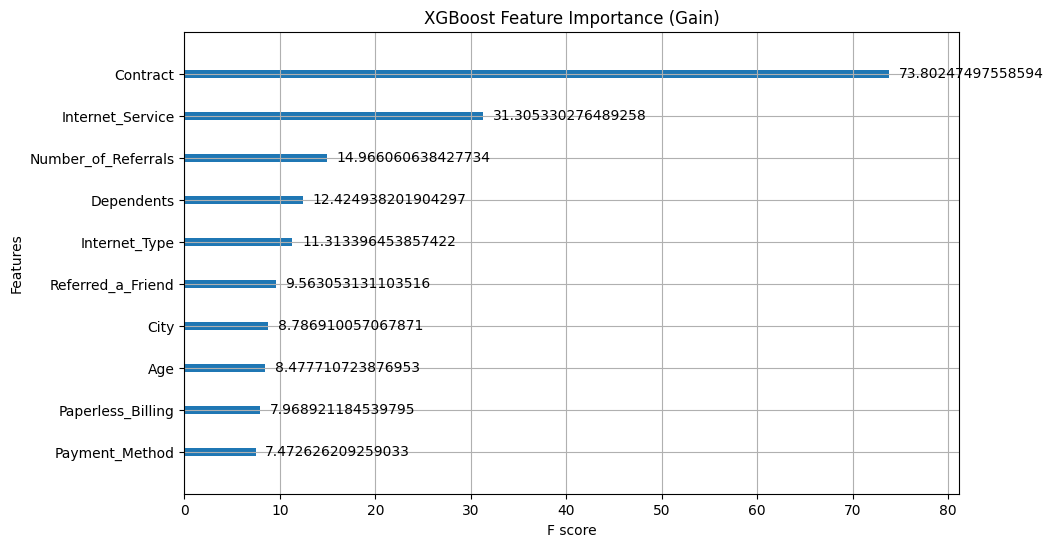

Top 5 Features by Gain:
                Feature  Importance_Gain
28             Contract        73.802475
17     Internet_Service        31.305330
11  Number_of_Referrals        14.966061
3            Dependents        12.424938
18        Internet_Type        11.313396


In [34]:
# 3. METHOD A: XGBoost Built-in Feature Importance
print("--- Method A: Built-in Feature Importance (Gain) ---")
# 'Gain' is the most popular metric; it measures the improvement in accuracy 
# brought by a feature to the branches it is on.

fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(clf_xgb, importance_type='gain', max_num_features=10, ax=ax, title='XGBoost Feature Importance (Gain)')
plt.show()

# You can also extract the raw scores into a DataFrame:
importance = clf_xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Importance_Gain']
).sort_values(by='Importance_Gain', ascending=False)
print("Top 5 Features by Gain:")
print(importance_df.head())

In [35]:
# # Assuming your DataFrame is named 'df'
# # Replace 'Suspicious_Feature' with the actual column name that has the gain of 229

# leak_correlation = df['Satisfaction_Score'].corr(df['Churn_val'])

# print(f"Correlation between the Suspicious Feature and Target: {leak_correlation:.4f}")

In [36]:
# print(pd.crosstab(df['Satisfaction_Score'], df['Churn_val'], normalize='index'))

In [37]:
# # 4. METHOD B: SHAP (SHapley Additive exPlanations) for Deeper Insight
# print("\n--- Method B: SHAP Values for Model Interpretation ---")
# # SHAP provides more reliable feature importance and explains individual predictions.

# # Create SHAP Explainer
# explainer = shap.TreeExplainer(clf_xgb)
# # Calculate SHAP values for the test set
# shap_values = explainer.shap_values(X_test)

# # Plot 1: SHAP Summary Plot (Global Feature Importance)
# # This plot shows the average magnitude of SHAP values for each feature.
# # It is often considered more stable and reliable than the built-in XGBoost importance.
# print("\nSHAP Summary Plot (Global Feature Ranking):")
# shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
# plt.title("SHAP Global Feature Importance")
# plt.show()

# # Plot 2: SHAP Decision Plot (Impact Visualization)
# # This plot shows the distribution of SHAP values for each feature.
# # Color represents the feature value (e.g., high value = red, low value = blue).
# print("SHAP Summary Plot (Feature Impact & Direction):")
# shap.summary_plot(shap_values, X_test, show=False)
# plt.show()

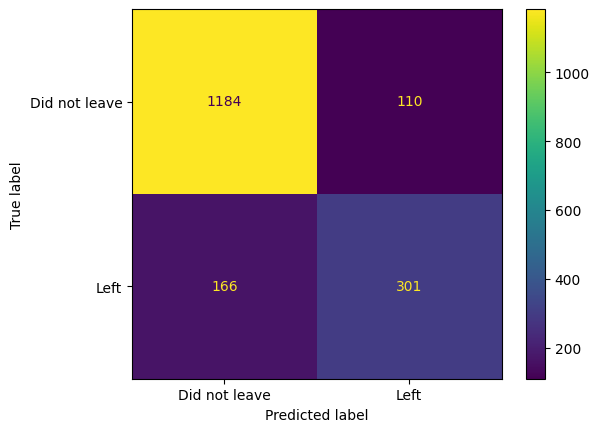

In [38]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did not leave', 'Left'])
disp.plot()
plt.show()

# Optimizing Parameters using Cross Validation and Grid Search()

In [39]:
scale_pos_weight_init_val = (len(y_train)- sum(y_train))/sum(y_train)
scale_pos_weight_init_val

2.767475035663338

In [40]:
# param_grid ={
#     'max_depth': [4],
#     'learning_rate' : [0.1],
#     'gamma': [0.25],
#     'reg_lambda': [0,1.0, 10.0],
#     'scale_pos_weight': [1,2,2.5,3.0,3.5 ,5] 
# }

# # 2. INITIALIZE MODEL AND CROSS-VALIDATION STRATEGY
# # Use StratifiedKFold for imbalanced data to ensure each fold has the same proportion of the target class.
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# #3. SET UP GRID SEARCH
# # We use 'roc_auc' as the scoring metric, which is standard for binary classification problems.
# grid_search = GridSearchCV(
#     estimator=clf_xgb,
#     param_grid=param_grid,
#     scoring='recall',         # Metric to optimize (AUC-ROC)
#     cv=cv,                     # Use Stratified K-Fold
#     verbose=3,                 # Controls the verbosity of the output
#     n_jobs=-1                  # Use all CPU cores for parallel processing
# )

# # 4. RUN THE SEARCH
# print("\n--- Starting Grid Search Cross-Validation ---")
# # 
# grid_search.fit(X_train, y_train)

# # 5. DISPLAY RESULTS
# print("\n--- Grid Search Results ---")

# # Best parameters found
# print(f"Best Parameters: {grid_search.best_params_}")

# # Best cross-validation score achieved
# print(f"Best CV AUC-PR Score: {grid_search.best_score_:.4f}")

# # Retrieve the best model
# best_xgb_model = grid_search.best_estimator_

# # Final evaluation on the unseen test set (crucial!)
# y_test_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]
# final_auc = roc_auc_score(y_test, y_test_pred_proba)

# print(f"\nFinal Test Set AUC-PR Score: {final_auc:.4f}")

In [41]:
# Best Parameters: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 1}
# Best CV ROC-AUC Score: 0.9132

# Final Test Set ROC-AUC Score: 0.9115

In [42]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
seed=42,
gamma=0.25,
learning_rate=0.1,
max_depth=4,
reg_lambda=0,
scale_pos_weight=3.0,
subsample=0.9,
colsample_bytree=0.5,
n_estimators=200,
 enable_categorical =True)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.64655
[1]	validation_0-aucpr:0.68264
[2]	validation_0-aucpr:0.70891
[3]	validation_0-aucpr:0.70520
[4]	validation_0-aucpr:0.72171
[5]	validation_0-aucpr:0.73664
[6]	validation_0-aucpr:0.74529
[7]	validation_0-aucpr:0.73293
[8]	validation_0-aucpr:0.74088
[9]	validation_0-aucpr:0.73913
[10]	validation_0-aucpr:0.73673
[11]	validation_0-aucpr:0.74515
[12]	validation_0-aucpr:0.75020
[13]	validation_0-aucpr:0.75052
[14]	validation_0-aucpr:0.75482
[15]	validation_0-aucpr:0.75218
[16]	validation_0-aucpr:0.75544
[17]	validation_0-aucpr:0.75769
[18]	validation_0-aucpr:0.76193
[19]	validation_0-aucpr:0.76114
[20]	validation_0-aucpr:0.76403
[21]	validation_0-aucpr:0.76034
[22]	validation_0-aucpr:0.75844


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[23]	validation_0-aucpr:0.75719
[24]	validation_0-aucpr:0.75899
[25]	validation_0-aucpr:0.75804
[26]	validation_0-aucpr:0.75531
[27]	validation_0-aucpr:0.75378
[28]	validation_0-aucpr:0.75322
[29]	validation_0-aucpr:0.75689
[30]	validation_0-aucpr:0.75923


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

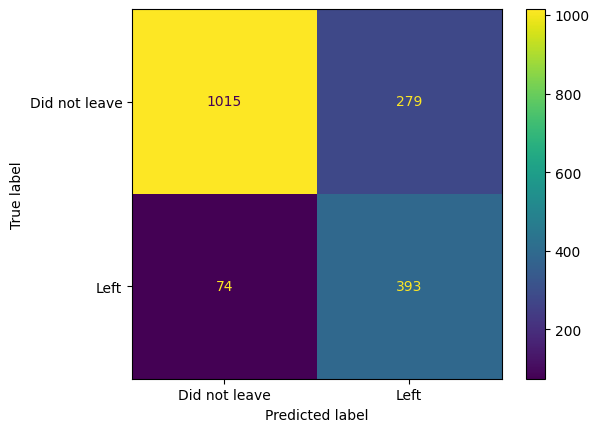

In [43]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did not leave', 'Left'])
disp.plot()
plt.savefig('confusion_matrix.png')
plt.show()

**Drawing an XGBoost Tree**

weight:  {'Age': 3.0, 'Dependents': 2.0, 'City': 4.0, 'Number_of_Referrals': 3.0, 'Offer': 1.0, 'Internet_Type': 1.0, 'Streaming_Movies': 1.0, 'Contract': 5.0, 'Payment_Method': 1.0, 'Monthly_Charge': 5.0, 'Total_Refunds': 1.0, 'Total_Long_Distance_Charges': 1.0, 'Total_Revenue': 1.0}
gain:  {'Age': 21.02828025817871, 'Dependents': 133.78155517578125, 'City': 65.30497741699219, 'Number_of_Referrals': 125.348876953125, 'Offer': 28.27886962890625, 'Internet_Type': 158.32110595703125, 'Streaming_Movies': 7.287599563598633, 'Contract': 757.0922241210938, 'Payment_Method': 52.49723815917969, 'Monthly_Charge': 66.67579650878906, 'Total_Refunds': 9.941436767578125, 'Total_Long_Distance_Charges': 101.13774108886719, 'Total_Revenue': 41.88563537597656}
cover:  {'Age': 152.54693603515625, 'Dependents': 672.760986328125, 'City': 464.43218994140625, 'Number_of_Referrals': 445.3590393066406, 'Offer': 743.61279296875, 'Internet_Type': 1018.6737670898438, 'Streaming_Movies': 36.44073486328125, 'Contr

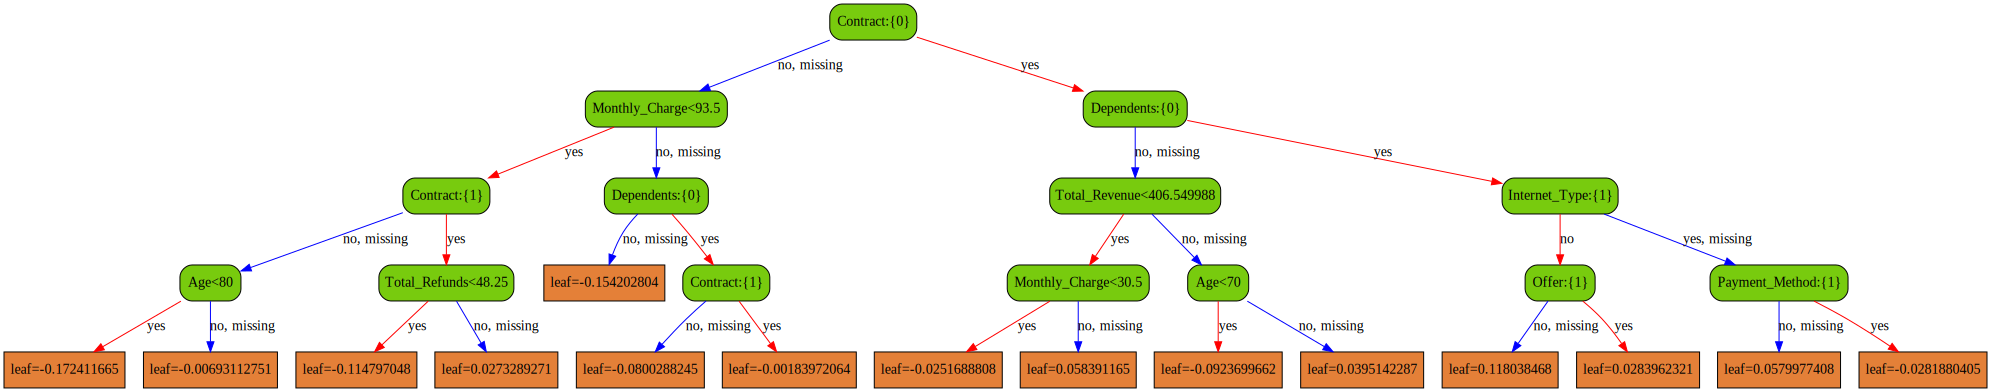

In [44]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
seed=42,
gamma=0.25,
learning_rate=0.1,
max_depth=4,
reg_lambda=10,
scale_pos_weight=3,
subsample=0.9,
colsample_bytree=0.5,
n_estimators=2,
                           enable_categorical=True)
clf_xgb.fit(X_train, y_train)

# weight is the number of times a feature is used to split the data across all trees.(no. of times a features is used in a branch or root across all trees)
# gain is the average gain across all splits the feature is used in.
# cover is the average coverage across all splits the feature is used in.
# total_gain is the total gain across all splits the feature is used in.
# total_cover is the total coverage across all splits the feature is used in.

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box', 'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=1, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)